# Frattali di Lichtenberg

Questa tipologia di frattali viene creata, solitamente, nei mezzi in cui si propaga della corrente: il fenomeno è *caotico*, siccome
diverse condizioni iniziali possono produrre dei risultati molto differenti. Come si può simulare questo processo?

L'idea di base è sempre quella di discretizzare lo spazio in cui la corrente scorre e assegnare ad ogni cella una probabilità:
è chiaro che la distribuzione della corrente che si propaga dev'essere tale da essere pari ad uno se consideriamo tutte le celle in cui la corrente non si è ancora propagata.

Noi cercheremo di simulare questi frattali usando il fenomeno fisico chiamato "rottura del dielettrico": nel momento in cui dei campi elettrici intensi vengono esercitati all'interno di un dielettrico questo si "rompe" facendo scorrere al suo interno una corrente.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numba import njit, prange

@njit(parallel=True)
def evolve_potential_kernel(potential, bonded_x, bonded_y, n_bonded, phi0, phi1, n_iter):
    n = potential.shape[0]
    for _ in range(n_iter):
        new_potential = potential.copy()
        for i in prange(1, n-1):
            for j in range(1, n-1):
                new_potential[i, j] = 0.25 * (
                    potential[i-1, j] + potential[i+1, j] +
                    potential[i, j-1] + potential[i, j+1]
                )
        for i in prange(n):
            new_potential[0, i] = phi1
            new_potential[-1, i] = phi1
            new_potential[i, 0] = phi1
            new_potential[i, -1] = phi1
        for k in range(n_bonded):
            new_potential[bonded_x[k], bonded_y[k]] = phi0
        potential[:, :] = new_potential


class DielectricBreakdown():
    """
    Class to simulate dielectric breakdown in a 2D grid
    """
    def __init__(self, n=100, eta=1., phi0=0., phi1=1., random_state=None):
        self.n = n
        self.eta = eta
        self.phi0 = phi0
        self.phi1 = phi1
        np.random.seed(random_state)
        self.lattice = np.zeros((n, n), dtype=np.int8)
        self.potential = np.zeros((n, n), dtype=np.float64)

        self.bonded_particles_x = np.zeros(n * n, dtype=np.int16)
        self.bonded_particles_y = np.zeros(n * n, dtype=np.int16)
        self.bonded_particles_age = np.zeros(n * n, dtype=np.int16)

        self.x_coords = (np.arange(0, self.n) * np.ones(self.n, dtype=np.int16)[:, np.newaxis]).T
        self.y_coords = (np.arange(0, self.n) * np.ones(self.n, dtype=np.int16)[:, np.newaxis])

        self.n_bonded_particles = 1
        self.bonded_particles_x[0] = n // 2
        self.bonded_particles_y[0] = n // 2
        self.lattice[n // 2, n // 2] = 1
        self.potential[n // 2, n // 2] = self.phi0

        self.potential[0, :] = self.phi1
        self.potential[-1, :] = self.phi1
        self.potential[:, 0] = self.phi1
        self.potential[:, -1] = self.phi1

        self.evolve_potential(10000)
        self.history = [self.potential.copy()]

    def evolve_potential(self, n_iter=50):
        evolve_potential_kernel(
            self.potential,
            self.bonded_particles_x,
            self.bonded_particles_y,
            self.n_bonded_particles,
            self.phi0,
            self.phi1,
            n_iter
        )

    def step(self):
        self.evolve_potential(20)

        n_bonded_neighbours = (
            np.roll(self.lattice, (0, 1), (0, 1)) +
            np.roll(self.lattice, (0, -1), (0, 1)) +
            np.roll(self.lattice, (1, 0), (0, 1)) +
            np.roll(self.lattice, (-1, 0), (0, 1))
        )

        candidates = (n_bonded_neighbours > 0) & (n_bonded_neighbours < 4)
        candidates_coords_x = self.x_coords[candidates]
        candidates_coords_y = self.y_coords[candidates]

        candidates_potential = self.potential[candidates]
        n_candidates = len(candidates_potential)
        candidates_probability = candidates_potential ** self.eta / np.sum(candidates_potential ** self.eta)
        chosen = np.random.choice(np.arange(n_candidates), p=candidates_probability)

        self.lattice[candidates_coords_x[chosen], candidates_coords_y[chosen]] = 1

        self.bonded_particles_x[self.n_bonded_particles] = candidates_coords_x[chosen]
        self.bonded_particles_y[self.n_bonded_particles] = candidates_coords_y[chosen]
        self.bonded_particles_age[:self.n_bonded_particles] += 1
        self.n_bonded_particles += 1

    def simulate(self, n_step):
        for _ in range(n_step):
            self.step()
            self.history.append(self.potential.copy())


model = DielectricBreakdown(n=500, eta=1.4, random_state=0)
model.simulate(6000)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
axs[0].imshow(model.lattice, cmap="Blues")
axs[0].axis("off")
axs[1].contour(model.potential, cmap="Blues_r")
axs[1].axis("off")
plt.show()


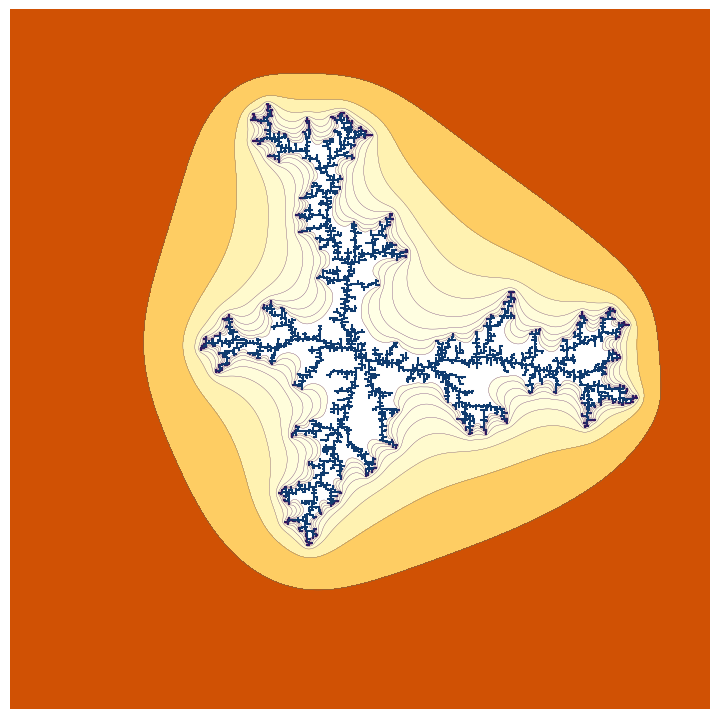

In [ ]:
i=6000
fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.contourf(model.history[i].T, cmap="YlOrBr", levels=np.logspace(-3,0,10))
ax.contour(model.history[i].T, levels=np.logspace(-3,0,10), linewidths=0.2)
ax.scatter(model.bonded_particles_x[:i], model.bonded_particles_y[:i], s=2., c="#103c6f", 
                linewidths=0.01, marker="s")
ax.axis("off")
plt.show()

In [ ]:
for i in range(0,6000,10):
    out_path = "./images/frame" + str(int(i/10)) + ".png"

    plt.figure()
    plt.contourf(model.history[i].T, cmap="YlOrBr", levels=np.logspace(-3,0,10))#, interpolation='spline36', interpolation_stage="rgba")
    plt.contour(model.history[i].T, levels=np.logspace(-3,0,10), linewidths=0.2)
    plt.scatter(model.bonded_particles_x[:i], model.bonded_particles_y[:i], s=0.7, c="#103c6f", 
                linewidths=0.01, marker="s")
    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close() 

E' possibile, usando il precedente script, generare con ffmpeg una bella gif.